<a href="https://colab.research.google.com/github/TylerBroda/ASL-Sign-Classification/blob/main/CSCI4050U_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CSCI 4050U: Final Project**
### **Completed by:** Tyler Broda & Shawn Yama

### **Dataset:** https://www.kaggle.com/datamunge/sign-language-mnist

The goal of our project is to implement a CNN (Convolutional Neural Network) to interpret American Sign Language signs from a set of images. Our hope is that the use of such a CNN could provide additional accessibility methods for deaf and hard-of-hearing individuals to interact and communicate with their smart devices and applications. For example during a video chat the model would enable the feature of sign language to speech. While the user signs, the computer would interpret that in audio.

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.datasets as datasets

import numpy as np
import matplotlib.pyplot as pl
import matplotlib.patches as patches
import pandas as pd

from random import randint

# **Loading & Validating our Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pip install kaggle
%cd /content/drive/MyDrive/Kaggle/

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle/"

!kaggle datasets download -d datamunge/sign-language-mnist
!unzip sign-language-mnist.zip -d sign-language-mnist
!ls

Mounted at /content/drive
/content/drive/MyDrive/Kaggle
sign-language-mnist.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sign-language-mnist.zip
replace sign-language-mnist/amer_sign2.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sign-language-mnist/amer_sign2.png  
  inflating: sign-language-mnist/amer_sign3.png  
  inflating: sign-language-mnist/american_sign_language.PNG  
  inflating: sign-language-mnist/sign_mnist_test.csv  
  inflating: sign-language-mnist/sign_mnist_test/sign_mnist_test.csv  
  inflating: sign-language-mnist/sign_mnist_train.csv  
  inflating: sign-language-mnist/sign_mnist_train/sign_mnist_train.csv  
kaggle.json			     PXL_20211212_220330567.PORTRAIT.jpg
PXL_20211212_220040886.PORTRAIT.jpg  PXL_20211212_221137738.PORTRAIT.jpg
PXL_20211212_220205765.PORTRAIT.jpg  sign-language-mnist
PXL_20211212_220229499.PORTRAIT.jpg  sign-language-mnist.zip
PXL_20211212_220319778.PORTRAIT.jpg


In [ ]:
train = pd.read_csv('./sign-language-mnist/sign_mnist_train.csv')
test = pd.read_csv('./sign-language-mnist/sign_mnist_test.csv')

# Divide x and y values for training and testing
y_train = train['label']
y_test = test['label']

x_train = train.drop('label', axis=1).values
x_test = test.drop('label', axis=1).values

In [ ]:
# Renormalize the image pixels to 0..1
x_train = x_train / 255
x_test = x_test / 255

# Reshape data
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

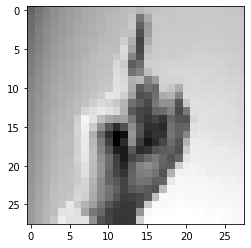

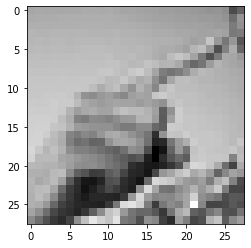

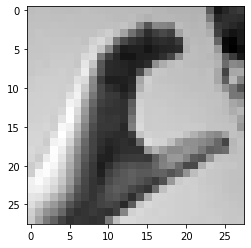

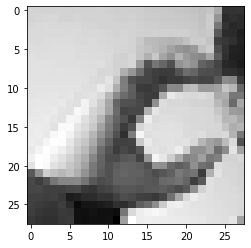

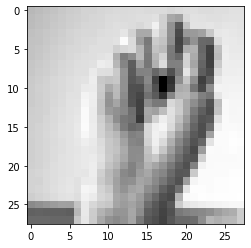

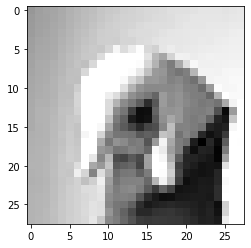

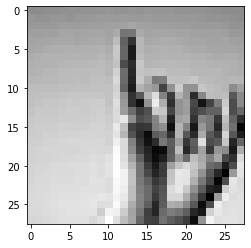

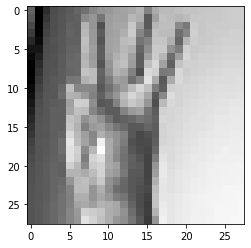

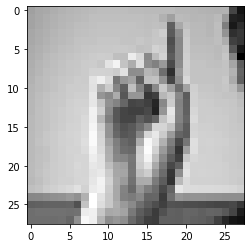

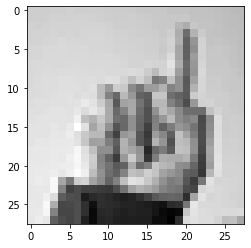

In [ ]:
# View the first 10 training cases
for i in range(10):
    reshaped_image = x_train[i].reshape(28, 28)
    pl.imshow(reshaped_image, cmap = "gray")
    pl.show()  

# **Our Model**


In [ ]:
# Compiles the model
def compile(model, learing_rate=0.01):
    model.compile(
        loss=losses.SparseCategoricalCrossentropy(),
        optimizer=optimizers.Adam(learing_rate),
        metrics=['sparse_categorical_accuracy']
    )

Our model takes an input of the dimensions of the image (28 height, 28 width). Then it is reshaped to have its grayscale channel represented. It goes through three 2D convolutional layers which each end off with a batch normalization and max pooling. Our first layer has 64 kernels, the second layer has 32 kernels and the third layer has 16 kernels, all with size (3 height, 3 width). Batch normalization is used to normalize the data after passing through a layer which stabilizes and speeds up the network. Max pooling is used to retrieve the maximum value for the patches while downsampling the data. Then we flatten the data so it can pass through dense layers (MLP). Finally it goes through one hidden layer, batch normalization is applied again and then goes through a dense output layer.

In [ ]:
model = models.Sequential([
    layers.Input(shape=(28,28), name='input'),
    layers.Reshape((28,28,1), name='reshape'),
    layers.Conv2D(64, (3,3), name='conv2d_0', padding='same', activation='relu'),
    layers.BatchNormalization(name='batchnorm_0'),
    layers.MaxPooling2D((2,2), strides=2, name='maxpooling_0'),
    layers.Conv2D(32, (3,3), name='conv2d_1', padding='same', activation='relu'),
    layers.BatchNormalization(name='batchnorm_1'),
    layers.MaxPooling2D((2,2), strides=2, name='maxpooling_1'),
    layers.Conv2D(16, (3,3), name='conv2d_2', padding='same', activation='relu'),
    layers.BatchNormalization(name='batchnorm_2'),
    layers.MaxPooling2D((2,2), strides=2, name='maxpooling_2'),
    layers.Flatten(name='flatten'),
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.BatchNormalization(name='batchnorm_4'),
    layers.Dense(28, activation='softmax', name='output'),
], name='deep_convnet')

compile(model)

In [ ]:
model.summary()

Model: "deep_convnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d_0 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 batchnorm_0 (BatchNormaliza  (None, 28, 28, 64)       256       
 tion)                                                           
                                                                 
 maxpooling_0 (MaxPooling2D)  (None, 14, 14, 64)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 14, 14, 32)       128       
 tion)                                                

Here the model is run.

In [ ]:
log = model.fit(x_train, y_train, epochs=15, validation_split=0.1)
train_acc = log.history['sparse_categorical_accuracy'][-1]
val_acc = log.history['val_sparse_categorical_accuracy'][-1]
test_acc = model.evaluate(x_test, y_test)[1]
train_hist = dict(train=train_acc, test=test_acc, validation=val_acc, history=log)
print(train_hist)

Epoch 1/15
773/773 [==============================] - 58s 74ms/step - loss: 0.3722 - sparse_categorical_accuracy: 0.8900 - val_loss: 0.5080 - val_sparse_categorical_accuracy: 0.8653
Epoch 2/15
773/773 [==============================] - 56s 73ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.9707 - val_loss: 0.4682 - val_sparse_categorical_accuracy: 0.8824
Epoch 3/15
773/773 [==============================] - 56s 72ms/step - loss: 0.0779 - sparse_categorical_accuracy: 0.9793 - val_loss: 0.0160 - val_sparse_categorical_accuracy: 0.9956
Epoch 4/15
773/773 [==============================] - 55s 71ms/step - loss: 0.0336 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.1219 - val_sparse_categorical_accuracy: 0.9643
Epoch 5/15
773/773 [==============================] - 56s 72ms/step - loss: 0.0562 - sparse_categorical_accuracy: 0.9866 - val_loss: 0.1586 - val_sparse_categorical_accuracy: 0.9607
Epoch 6/15
773/773 [==============================] - 56s 72ms/step - loss: 0.0486 - spars

# **Analysis**

In [ ]:
history = train_hist.get('history')
history.history

{'loss': [0.37217509746551514,
  0.10372766107320786,
  0.07790204882621765,
  0.033551547676324844,
  0.05621691420674324,
  0.048603761941194534,
  0.03586749732494354,
  0.07191963493824005,
  0.015962209552526474,
  0.06498859077692032,
  0.024877797812223434,
  0.04285512864589691,
  0.07035575807094574,
  0.019569657742977142,
  0.07009216398000717],
 'sparse_categorical_accuracy': [0.8899590969085693,
  0.9707394242286682,
  0.9793192744255066,
  0.9925937652587891,
  0.9865636229515076,
  0.9889513850212097,
  0.9914606213569641,
  0.9857541918754578,
  0.9966409206390381,
  0.989801287651062,
  0.9957100749015808,
  0.9934436678886414,
  0.9895179867744446,
  0.9963980913162231,
  0.9906511902809143],
 'val_loss': [0.5079940557479858,
  0.46817517280578613,
  0.015969358384609222,
  0.12191654741764069,
  0.15859775245189667,
  0.06826192140579224,
  0.623239278793335,
  0.010619927197694778,
  0.26717230677604675,
  0.022681880742311478,
  0.03244471549987793,
  0.05396628752

In [ ]:
epochs = [i for i in range(15)]
train_acc = history.history['sparse_categorical_accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_sparse_categorical_accuracy']
val_loss = history.history['val_loss']

Here we are comparing the training accuracy with the validation accuracy. These graphs end up converging closely.

Text(0, 0.5, 'Accuracy')

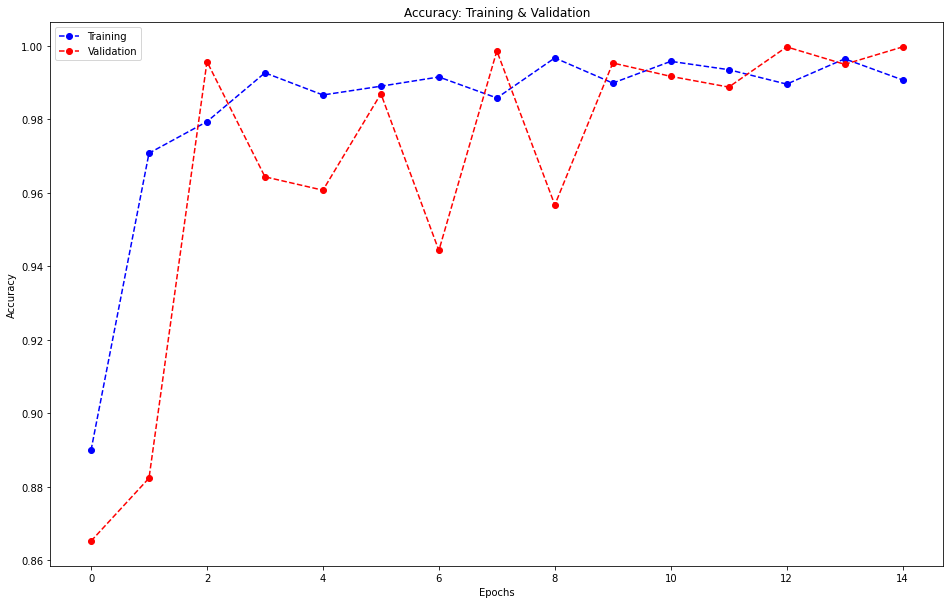

In [ ]:
fig, ax = pl.subplots()

fig.set_size_inches(16, 10)
ax.plot(epochs, train_acc, 'bo-' , linestyle='--', label='Training')
ax.plot(epochs, val_acc, 'ro-' , linestyle='--', label='Validation')
ax.set_title('Accuracy: Training & Validation')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')

Here we are comparing the test accuracy with the validation accuracy. These graphs also end up converging closely.

Text(0, 0.5, 'Loss')

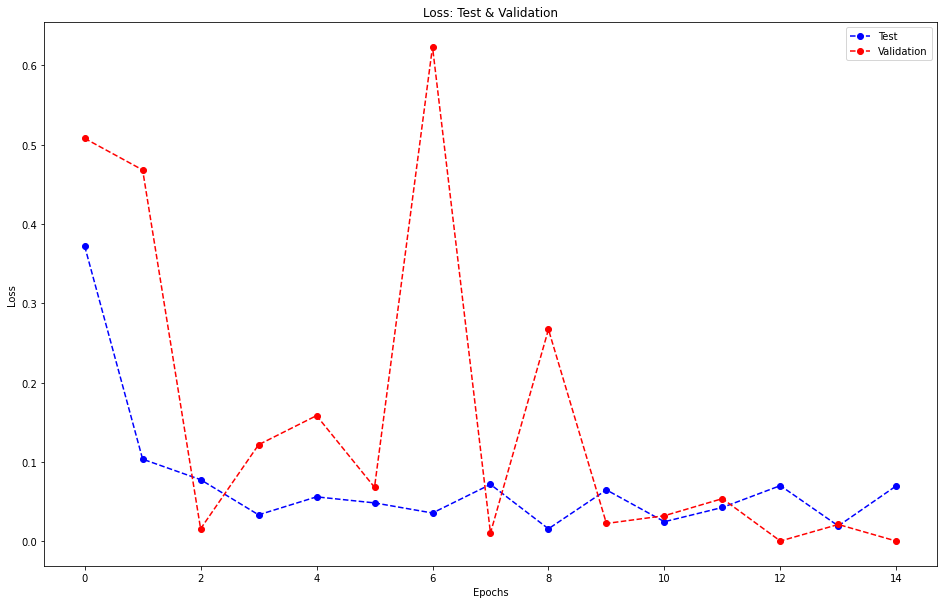

In [ ]:
fig, ax = pl.subplots()

fig.set_size_inches(16, 10)
ax.plot(epochs, train_loss, 'bo-', linestyle='--', label='Test')
ax.plot(epochs, val_loss, 'ro-', linestyle='--', label='Validation')
ax.set_title('Loss: Test & Validation')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

In [ ]:
predictions = model.predict(x_test)
predictions

array([[4.9943371e-34, 1.2974805e-25, 8.1650367e-11, ..., 5.9621979e-21,
        6.3662950e-21, 1.7649530e-20],
       [3.4734822e-33, 2.5430084e-26, 0.0000000e+00, ..., 2.7930572e-32,
        6.5676162e-33, 5.1039724e-32],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.5562020e-37, 6.8647699e-31, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [ ]:
# Taking the highest val from the predictions
classes = np.argmax(predictions, axis = 1)
print(classes)

[ 6  5 10 ...  2  4  2]


Here are some random sign language gestures that were predicted by our model. For the most part our model predicts the correct class.

[3972, 3486, 4810, 2438, 1020, 5113, 5126, 839, 3588, 7102]




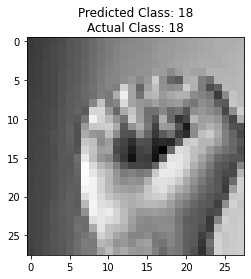

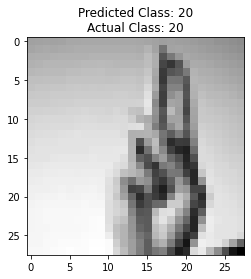

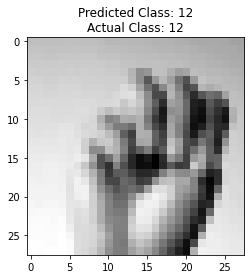

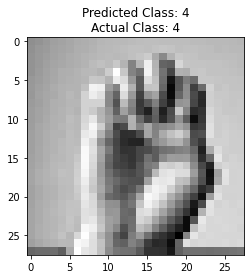

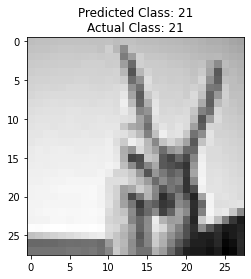

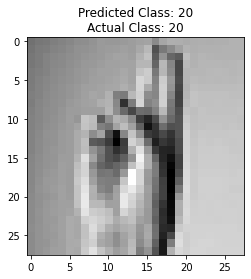

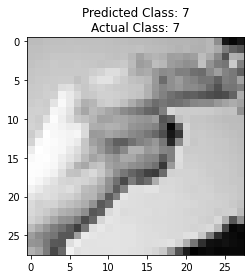

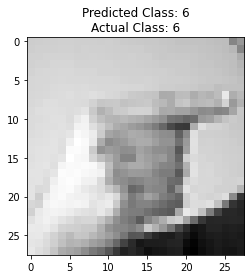

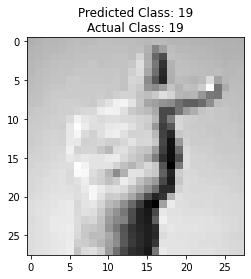

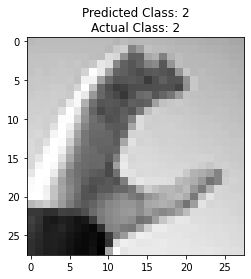

In [ ]:
# A few random samples
rand_samples = [randint(0, 7171) for i in range(0, 10)]
print(rand_samples)
print('\n')

# Generate plots for samples
for sample in rand_samples:
  reshaped_image = x_test[sample].reshape((28, 28))
  pl.imshow(reshaped_image, cmap = "gray")
  pl.title("Predicted Class: {}\nActual Class: {}".format(classes[sample], y_test[sample]))
  pl.show()

Now we are testing specific instances of sign language images. Shawn's hand doing signs of A, B and V scaled down to 28x28 would be analyzed here.

In [ ]:
from PIL import Image, ImageOps
from numpy import asarray

In [ ]:
imageA = Image.open('./instances/A.jpg')
imageB = Image.open('./instances/B.jpg')
imageV = Image.open('./instances/V.jpg')

imageA = ImageOps.grayscale(imageA)
imageB = ImageOps.grayscale(imageB)
imageV = ImageOps.grayscale(imageV)

imageA_np = asarray(imageA).flatten()
imageB_np = asarray(imageB).flatten()
imageV_np = asarray(imageV).flatten()

instances = np.array([imageA_np, imageB_np, imageV_np])

# Renormalize the image pixels to 0..1
instances = instances / 255

# Reshape data
instances = instances.reshape(-1, 28, 28, 1)

In [ ]:
predict_instances = model.predict(instances)
predict_instances

array([[2.53158652e-19, 9.50973038e-15, 1.05767685e-25, 6.50193989e-23,
        3.91436553e-25, 1.00000000e+00, 2.42834031e-28, 2.73010498e-17,
        0.00000000e+00, 5.93529269e-26, 4.29175866e-28, 2.52923130e-34,
        4.23944276e-29, 1.95840051e-20, 6.78450435e-32, 0.00000000e+00,
        1.51449108e-18, 0.00000000e+00, 3.80609028e-35, 4.90595161e-25,
        2.44467990e-28, 1.41884314e-38, 1.72966904e-33, 7.34632326e-26,
        7.53280360e-24, 2.63385200e-25, 2.63911197e-25, 2.93526071e-25],
       [0.00000000e+00, 1.87978401e-15, 0.00000000e+00, 8.20628029e-31,
        5.53680915e-37, 1.00000000e+00, 1.00784535e-33, 1.22025218e-32,
        4.43154662e-26, 9.90201999e-32, 3.02778892e-25, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.69514564e-28, 3.71735439e-13,
        1.53821335e-31, 5.29182320e-33, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.14212070e-29, 4.07606381e-31,
        3.85677126e-23, 1.19361001e-31, 2.25817190e-31, 5.64897

In [ ]:
# Taking the highest val from the predictions
classes_inst = np.argmax(predict_instances, axis = 1)
print(classes_inst)

[ 5  5 11]


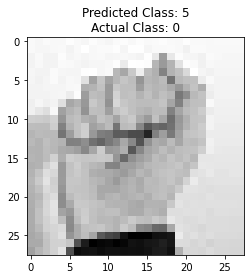

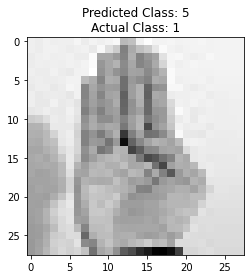

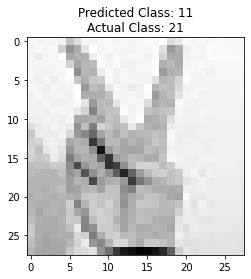

In [ ]:
actual_classes = [0,1,21] # Hardcoded A, B, V

for i in range(len(instances)):
  reshaped_image = instances[i].reshape((28, 28))
  pl.imshow(reshaped_image, cmap = "gray")
  pl.title("Predicted Class: {}\nActual Class: {}".format(classes_inst[i], actual_classes[i]))
  pl.show()